This is a test notebook to produce an image from HLS using s3 urls from the LP DAAC. 

Import the python libraries required for running the script

In [1]:
import boto3
import datetime
import numpy as np
import rasterio as rio
import rioxarray
import requests

from PIL import Image, ImageDraw, ImageFont
from rasterio.session import AWSSession

Initialize configuration. Image type accepts both multiband combinations and simple band math. Currently configured types are "SWIR", "CIR", "TC", "NDVI", "MNDWI2". The SWIR and CIR are false color composite band combinations. The TC is a true color (RGB) image. and NDVI and MNDWI2 are indices used for vegetation and water respectively.

In [24]:
image_type = "TC"
low_value = np.e
high_value = 255
low_threshold = np.log(100)
high_threshold = np.log(7500)

Provide the s3 bucket and key to read data in place

In [31]:
s3_bucket = "lp-prod-protected"
s3_prefix = "HLSL30.020/HLS.L30.T10TFK.2020270T184534.v2.0/HLS.L30.T10TFK.2020270T184534.v2.0"
s3_prefix = "HLSL30.020/HLS.L30.T17NMJ.2023069T154235.v2.0/HLS.L30.T17NMJ.2023069T154235.v2.0"
s3_prefix = "HLSS30.020/HLS.S30.T27XVH.2021227T153809.v2.0/HLS.S30.T27XVH.2021227T153809.v2.0"

Spectral Bands are not consistent between the HLSS30 and the HLSL30 products. Additionally, we configure a lookup table for some common band combinations to give users a starting point with generating HLS images.

In [32]:
product = s3_prefix.split("/")[-1].split(".")[1]
band_lut = {
    "S30": {
        "SWIR": ["12","8A","04"],
        "CIR": ["8A","04","03"],
        "TC": ["04","03","02"],
        "NDVI": ["08","04"],
        "MNDWI2": ["03","12"],
        "NBR": ["8A","12"],
        "NBR2": ["11","12"]
    },
    "L30": {
        "SWIR": ["07","05","04"],
        "CIR": ["05","04","03"],
        "TC": ["04","03","02"],
        "NDVI": ["05","04"],
        "MNDWI2":["03","07"],
        "NBR": ["05","07"],
        "NBR2": ["06","07"]
    }
}

bands = band_lut[product][image_type]

Again, following the example from [this guide from NASA Openscapes](https://nasa-openscapes.github.io/2021-Cloud-Workshop-AGU/how-tos/Earthdata_Cloud__Single_File__Direct_S3_Access_COG_Example.html), we open the data files in place with rioxarray. Note that currently, the memory available on the kernel cannot support a full HLS tile (3660 x 3660 pixels). The example below subsets this particular HLS scene over Mt. Kilauea in Hawaii. This will need to be adjusted for other HLS tiles (e.g. 05QKB).

In [65]:
band_data = []
for band in bands:
    file = f"s3://{s3_bucket}/{s3_prefix}.B{band}.tif"
    print(file)
    band_data.append(rioxarray.open_rasterio(file))
band1 = band_data[0].squeeze()
band2 = band_data[1].squeeze()
if len(band_data) > 2:
    band3 = band_data[2].squeeze()
band1 = band1[3000:3660,3000:3660]
band2 = band2[3000:3660,3000:3660]
band3 = band3[3000:3660,3000:3660]

s3://lp-prod-protected/HLSS30.020/HLS.S30.T27XVH.2021227T153809.v2.0/HLS.S30.T27XVH.2021227T153809.v2.0.B04.tif
s3://lp-prod-protected/HLSS30.020/HLS.S30.T27XVH.2021227T153809.v2.0/HLS.S30.T27XVH.2021227T153809.v2.0.B03.tif
s3://lp-prod-protected/HLSS30.020/HLS.S30.T27XVH.2021227T153809.v2.0/HLS.S30.T27XVH.2021227T153809.v2.0.B02.tif


Image scaling is required for the TC and FCC imagery. The cell below is not and should not be applied for HLS-derived indices.

In [66]:
if image_type in ["SWIR", "CIR", "TC"]:
    rgb = [band1, band2, band3]
    rgb = np.array(rgb)
    rgb = np.log(rgb)
    print(rgb.shape)
    rgb[np.where(rgb <= low_threshold)] = low_value
    rgb[np.where(rgb >= high_threshold)] = high_value

    indices = np.where(
        (rgb > low_value) & (rgb < high_value)
    )

    rgb[indices] = (high_value * (rgb[indices] - low_threshold) / (high_threshold - low_threshold)
    )
    rgb = rgb.astype(rio.uint8)

(3, 660, 660)


/tmp/ipykernel_386/3311781634.py:4: RuntimeWarning: divide by zero encountered in log
  rgb = np.log(rgb)
/tmp/ipykernel_386/3311781634.py:4: RuntimeWarning: invalid value encountered in log
  rgb = np.log(rgb)


Most of the derived indices using optical data will be consistent in their algorithm. Should the desired image be an index, we leverage the simple equation in the cell below.

In [67]:
if image_type in ["NDVI", "MNDWI2", "NBR", "NBR2"]:
    rgb = (band1 - band2) / (band1 + band2)
    rgb = np.array(rgb)
    #remove unnecessary first dimension
    rgb = rgb[0]

Lastly, we want to plot the images. Plotting is different for indices than it is for 3-band imagery as indices typically have a colormap applied whereas 3-band imagery is treated as RGB regardless of the input bands.

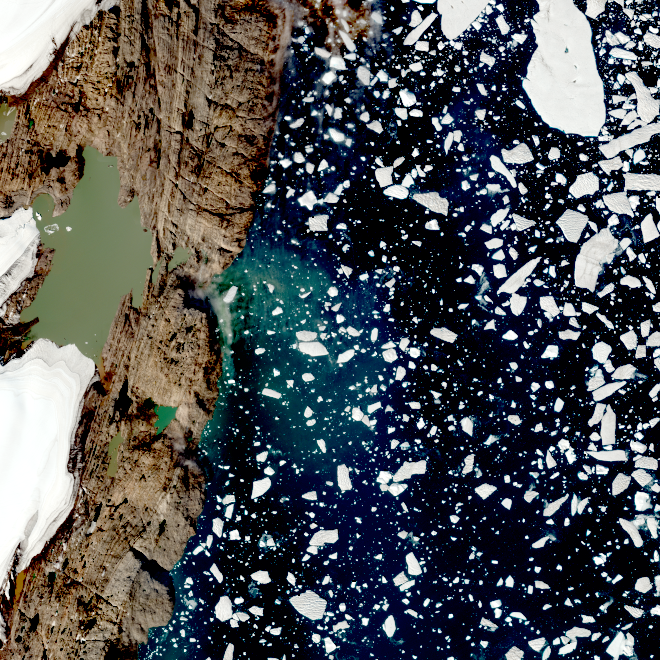

In [68]:
if image_type in ["SWIR", "CIR", "TC"]:
    rgb = np.rollaxis(rgb, 0, 3)
    img = Image.fromarray(rgb)

elif image_type in ["NDVI", "MNDWI2", "NBR","NBR2"]:
    import matplotlib.pyplot as plt
    from matplotlib import colors
    norm = colors.Normalize(vmin=-0.5,vmax=0.5,clip=True)
    plt.pcolormesh(rgb[::-1,:],cmap = "RdYlGn", norm=norm)
    plt.show()
    #cmap = plt.cm.RdYlGn(rgb)
    #img = Image.fromarray(np.uint8(cmap*255))
display(img)